# Pixel binning for NGC 309

In [1]:
import numpy as np
import math
import sys
import os
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

global PIXEDFIT_HOME
PIXEDFIT_HOME = os.environ['PIXEDFIT_HOME']
sys.path.insert(0, PIXEDFIT_HOME+'/src')

### Call function pixel_binning_specphoto for performing pixel binning

In [2]:
from piXedfit_spectrophotometric import pixel_binning_specphoto

specphoto_map_fits = "match_specphoto_crop_fluxmap_califa_NGC309.fits.gz"
fits_binmap = "pixbin_crop_fluxmap_califa_NGC309.fits"
out_fits_name = "pixbin_match_specphoto_crop_fluxmap_califa_NGC309.fits"
pixbin = pixel_binning_specphoto(specphoto_map_fits=specphoto_map_fits, 
                                 fits_binmap=fits_binmap, out_fits_name=out_fits_name)

Number of photometric bins: 212
Number of spectroscopic bins: 108


### Check FITS file containing spectrophotometric data cube after pixel binning

In [3]:
hdu_binmap = fits.open("pixbin_match_specphoto_crop_fluxmap_califa_NGC309.fits")
hdu_binmap.info()
header = hdu_binmap[0].header
print (header)

Filename: pixbin_match_specphoto_crop_fluxmap_califa_NGC309.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      24   ()      
  1  PHOTO_BIN_FLAG    1 ImageHDU         8   (131, 131)   float64   
  2  SPEC_BIN_FLAG    1 ImageHDU         8   (131, 131)   float64   
  3  BIN_PHOTO_FLUX    1 ImageHDU         9   (131, 131, 12)   float64   
  4  BIN_PHOTO_FLUXERR    1 ImageHDU         9   (131, 131, 12)   float64   
  5  SPEC_WAVE     1 ImageHDU         7   (1899,)   float64   
  6  BIN_SPEC_FLUX    1 ImageHDU         9   (131, 131, 1899)   float64   
  7  BIN_SPEC_FLUXERR    1 ImageHDU         9   (131, 131, 1899)   float64   
  8  MOD_WAVE      1 ImageHDU         7   (4942,)   float64   
  9  BIN_MOD_FLUX    1 ImageHDU         9   (131, 131, 4942)   float64   
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =          

In [4]:
photo_bin_flag = hdu_binmap['photo_bin_flag'].data
spec_bin_flag = hdu_binmap['spec_bin_flag'].data
bin_photo_flux = hdu_binmap['bin_photo_flux'].data
bin_photo_flux_err = hdu_binmap['bin_photo_fluxerr'].data
spec_wave = hdu_binmap['spec_wave'].data
bin_spec_flux = hdu_binmap['bin_spec_flux'].data
bin_spec_flux_err = hdu_binmap['bin_spec_fluxerr'].data
mod_wave = hdu_binmap['mod_wave'].data
bin_mod_flux = hdu_binmap['bin_mod_flux'].data

### Plot the binning map

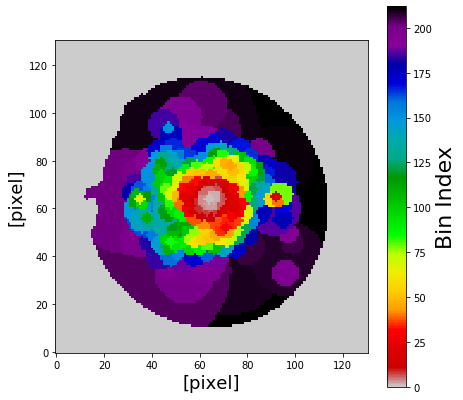

In [5]:
## plot pixel binning map:
fig1 = plt.figure(figsize=(7,7))
f1 = plt.subplot()
plt.xlabel("[pixel]", fontsize=18)
plt.ylabel("[pixel]", fontsize=18)
    
plt.imshow(photo_bin_flag, origin='lower', cmap='nipy_spectral_r')
cb = plt.colorbar()
cb.set_label(label='Bin Index', fontsize=22)
plt.savefig("pixbin.png")

### Get region covered by the IFU fibre bundle: for plotting

In [6]:
specphoto = fits.open("match_specphoto_crop_fluxmap_califa_NGC309.fits.gz")
specphoto.info()
print (specphoto[0].header)

Filename: match_specphoto_crop_fluxmap_califa_NGC309.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      21   ()      
  1  PHOTO_REGION    1 ImageHDU         8   (131, 131)   float64   
  2  SPEC_REGION    1 ImageHDU         8   (131, 131)   float64   
  3  PHOTO_FLUX    1 ImageHDU         9   (131, 131, 12)   float64   
  4  PHOTO_FLUXERR    1 ImageHDU         9   (131, 131, 12)   float64   
  5  WAVE          1 ImageHDU         7   (1899,)   float64   
  6  SPEC_FLUX     1 ImageHDU         9   (131, 131, 1899)   float64   
  7  SPEC_FLUXERR    1 ImageHDU         9   (131, 131, 1899)   float64   
  8  MOD_WAVE      1 ImageHDU         7   (4942,)   float64   
  9  MOD_FLUX      1 ImageHDU         9   (131, 131, 4942)   float64   
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of a

### Plot spatial bins that have spectroscopic and photomeric SEDs 

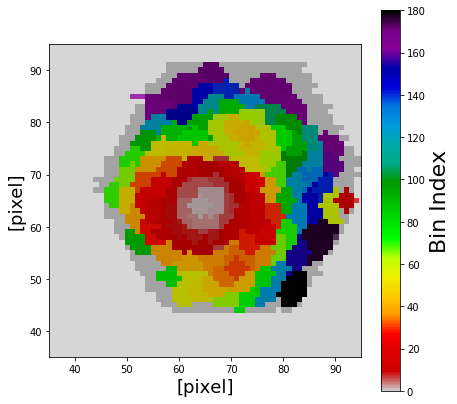

In [7]:
x_cent = 65
y_cent = 65

## plot pixel binning map:
fig1 = plt.figure(figsize=(7,7))
f1 = plt.subplot()
plt.xlabel("[pixel]", fontsize=18)
plt.ylabel("[pixel]", fontsize=18)
plt.xlim(x_cent-30,x_cent+30)
plt.ylim(y_cent-30,y_cent+30)

plt.imshow(spec_bin_flag, origin='lower', cmap='nipy_spectral_r')
cb = plt.colorbar()
cb.set_label(label='Bin Index', fontsize=22)

plt.imshow(specphoto['spec_region'].data*10, origin='lower', 
           cmap='Greys', alpha=0.2, vmin=0, vmax=9)

### Get the set of photometric filters and their central wavelengths

In [8]:
### get effective wavelength of the filters:
nbands = int(header['nfilters'])
filters = []
for ii in range(0,nbands):
    str_temp = 'fil%d' % ii
    filters.append(header[str_temp])

from filtering import cwave_filters

photo_wave = cwave_filters(filters)
print (photo_wave)

[ 1516.  2267.  3351.  4686.  6166.  7480.  8932. 12358. 16458. 21603.
 33526. 46028.]


### Get SEDs of spatial bins

In [9]:
nbins_photo = int(header['nbins_photo'])
nbins_spec = int(header['nbins_spec'])
unit = float(header['unit'])
nwaves = len(spec_wave)
dim_y = photo_bin_flag.shape[0]
dim_x = photo_bin_flag.shape[1]
#transpose photometric SEDs from (band,y,x) => (y,x,band):
bin_photo_flux_trans = np.transpose(bin_photo_flux, axes=(1, 2, 0))*unit
bin_photo_flux_err_trans = np.transpose(bin_photo_flux_err, axes=(1, 2, 0))*unit

bin_spec_flux_trans = np.transpose(bin_spec_flux, axes=(1, 2, 0))*unit
bin_spec_flux_err_trans = np.transpose(bin_spec_flux_err, axes=(1, 2, 0))*unit
bin_mod_flux_trans = np.transpose(bin_mod_flux, axes=(1,2,0))*unit

bin_photo_SED = np.zeros((nbins_photo,nbands))
bin_photo_SED_err = np.zeros((nbins_photo,nbands))
bin_spec_SED = np.zeros((nbins_photo,nwaves))
bin_spec_SED_err = np.zeros((nbins_photo,nwaves))
bin_mod_SED = np.zeros((nbins_photo,len(mod_wave)))

for yy in range(0,dim_y):
    for xx in range(0,dim_x):
        if photo_bin_flag[yy][xx] > 0:
            bin_id = photo_bin_flag[yy][xx] - 1
            bin_photo_SED[int(bin_id)] = bin_photo_flux_trans[yy][xx]
            bin_photo_SED_err[int(bin_id)] = bin_photo_flux_err_trans[yy][xx]
            
        if spec_bin_flag[yy][xx] > 0:
            bin_id = spec_bin_flag[yy][xx] - 1
            bin_spec_SED[int(bin_id)] = bin_spec_flux_trans[yy][xx]
            bin_spec_SED_err[int(bin_id)] = bin_spec_flux_err_trans[yy][xx]
            bin_mod_SED[int(bin_id)] = bin_mod_flux_trans[yy][xx]

### Plot first 20 bins
For bin spectrophotometric SED, the blue squares: photometric SED, red: spectroscopic SED, black: superposition of best-fit model SEDs of the bin's member pixels (the model SED that was used in rescaling the IFS spectra)

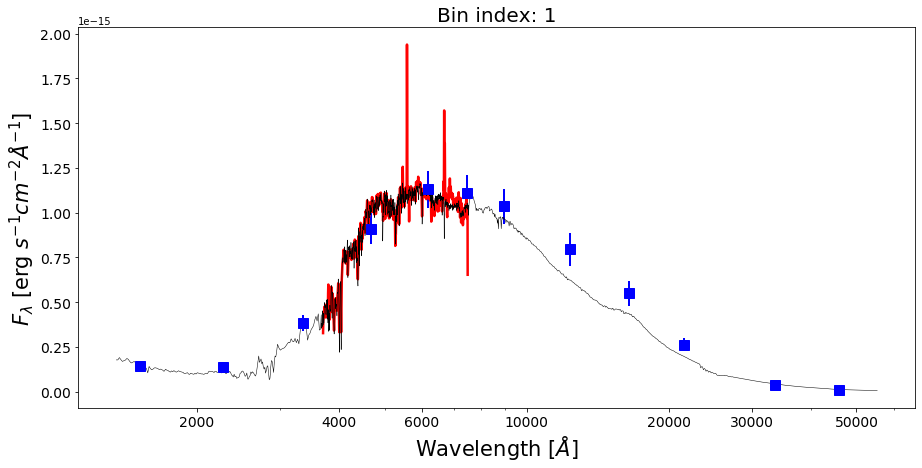

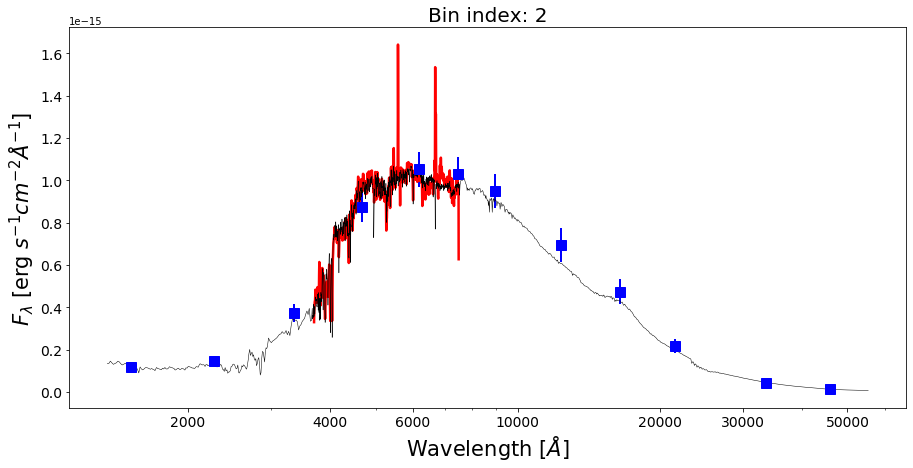

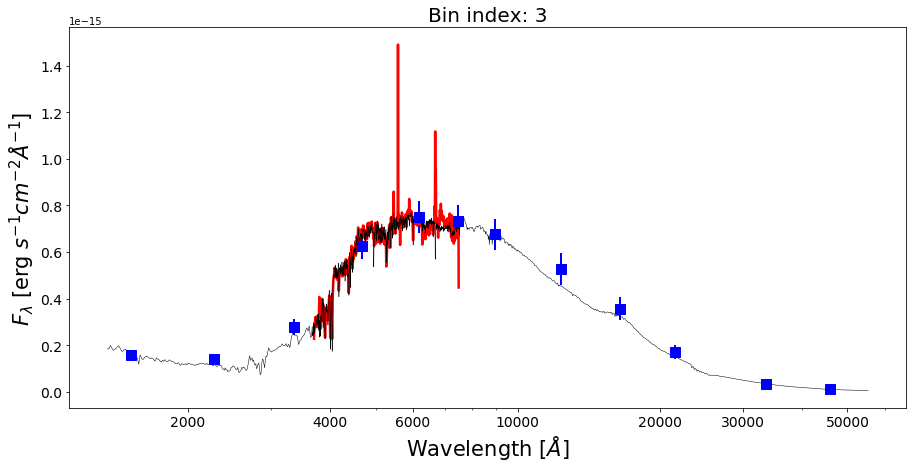

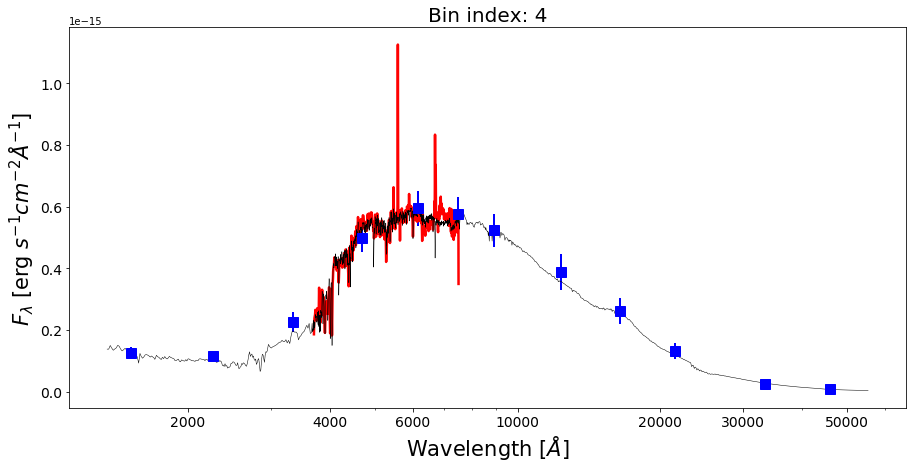

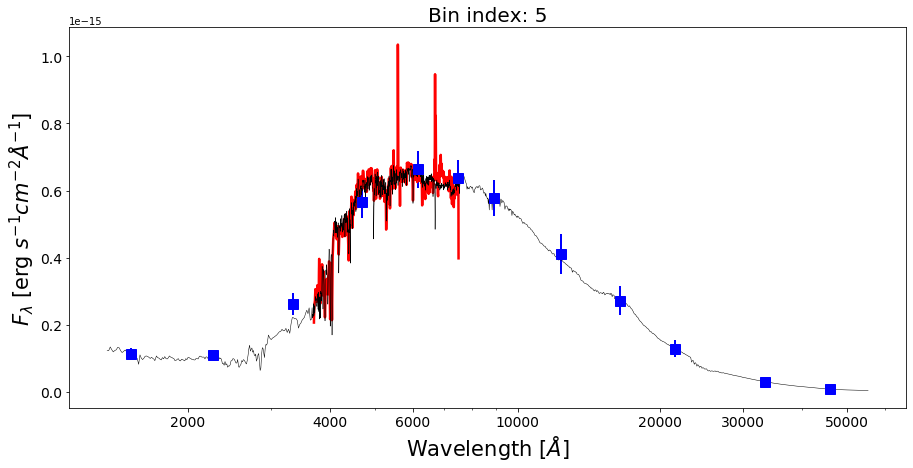

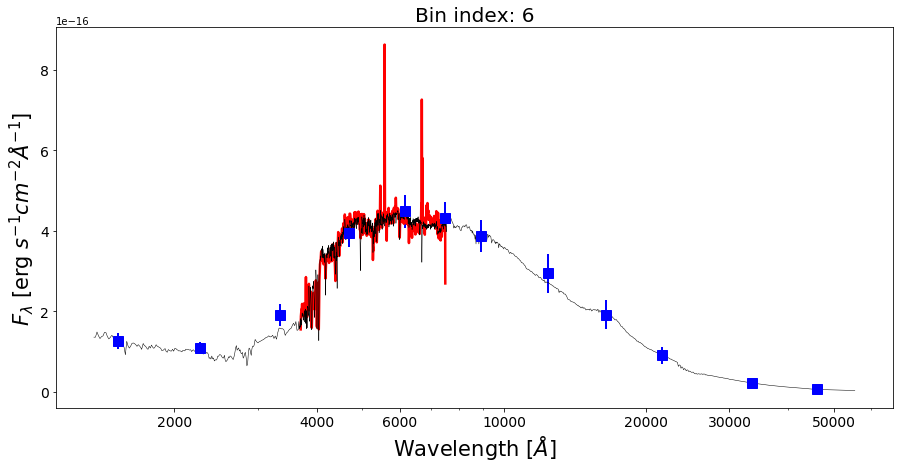

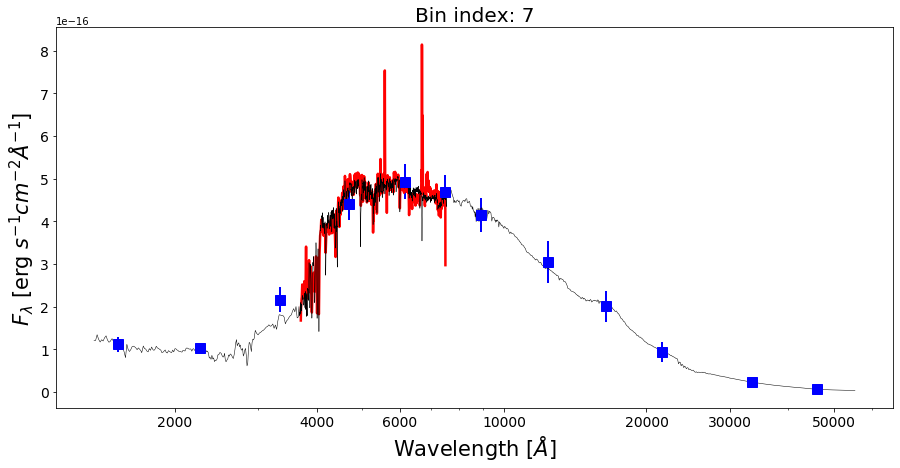

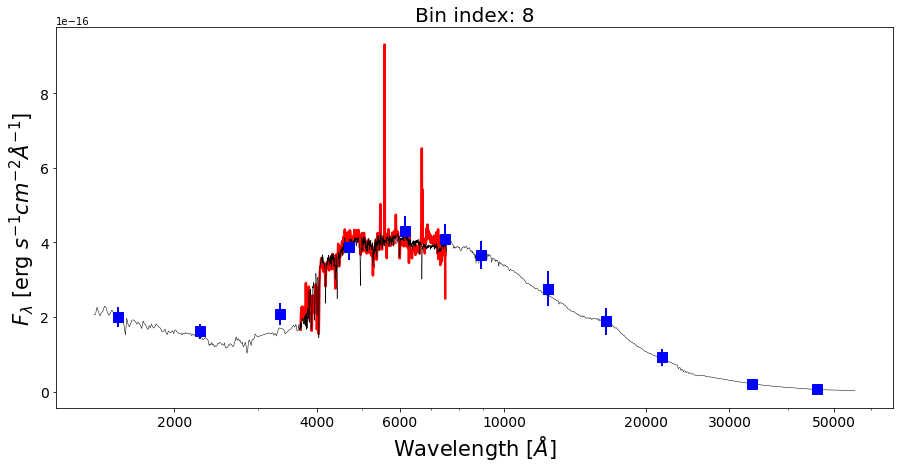

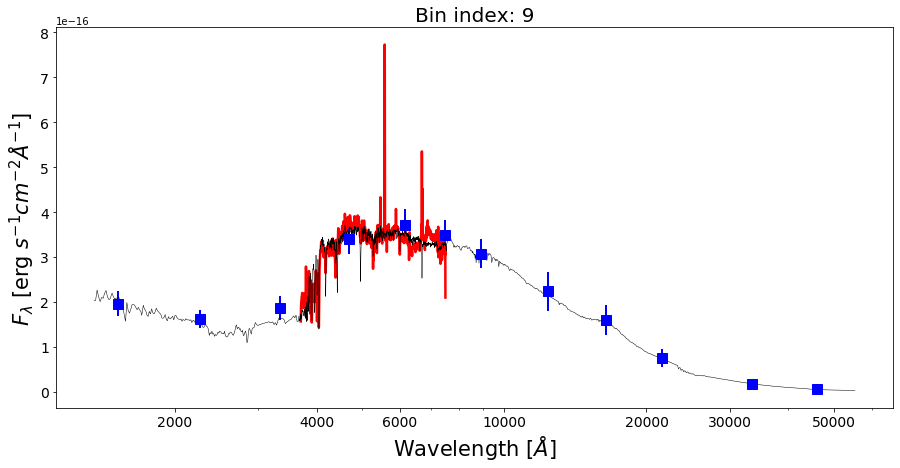

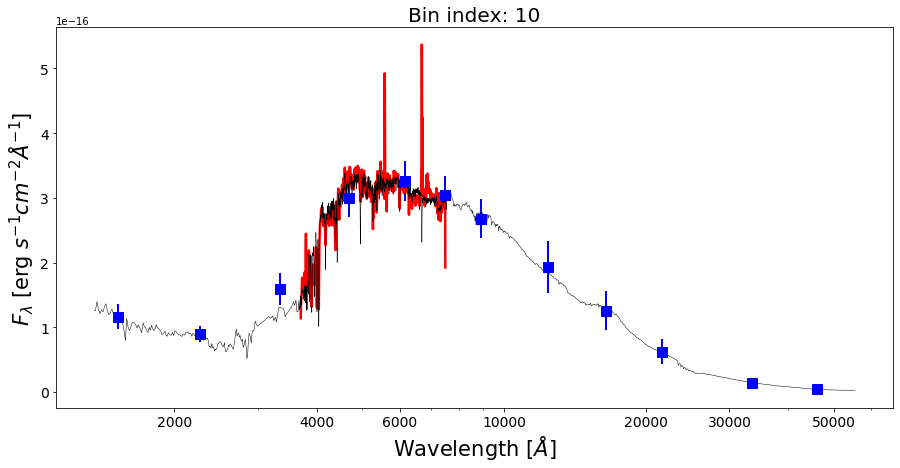

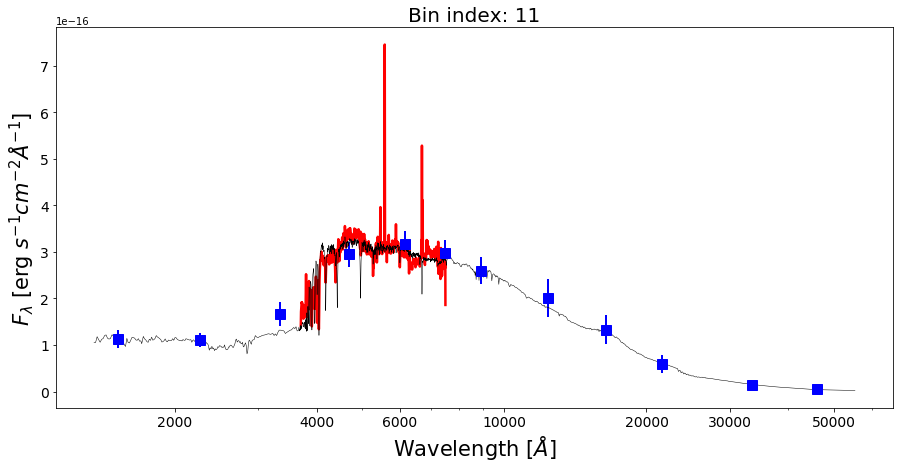

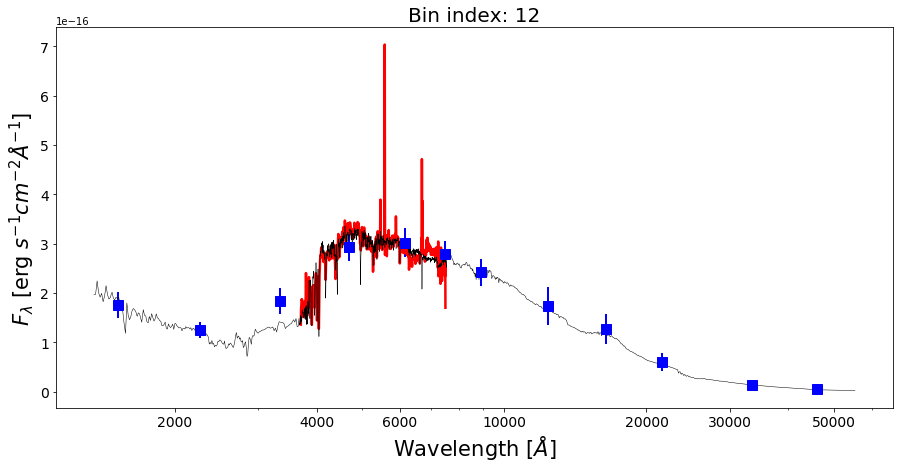

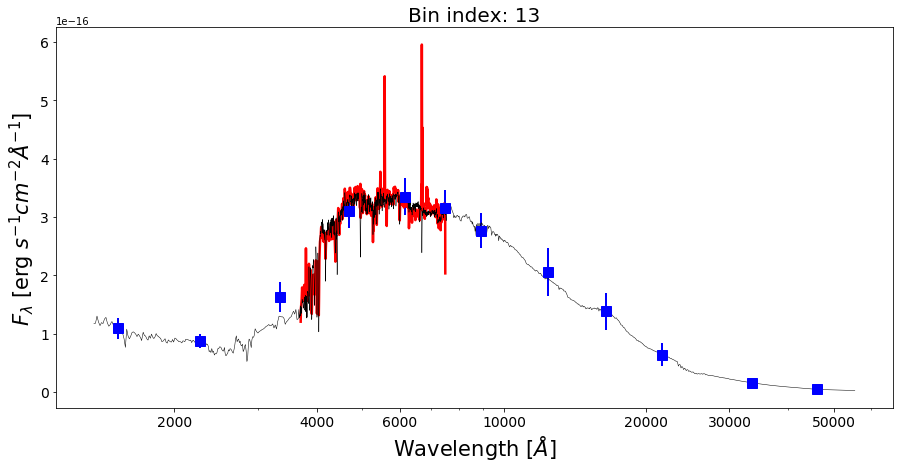

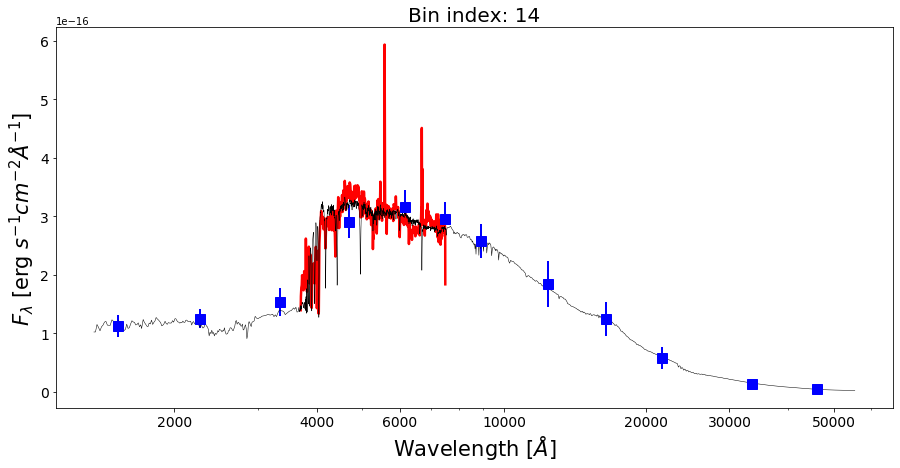

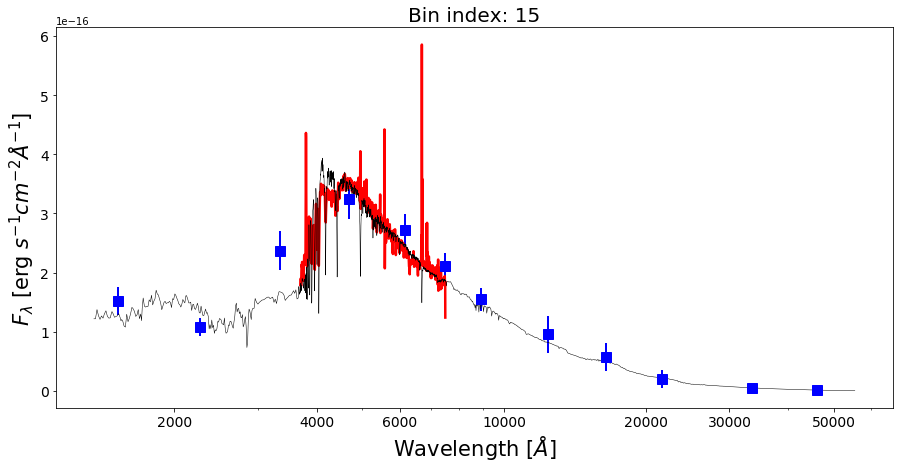

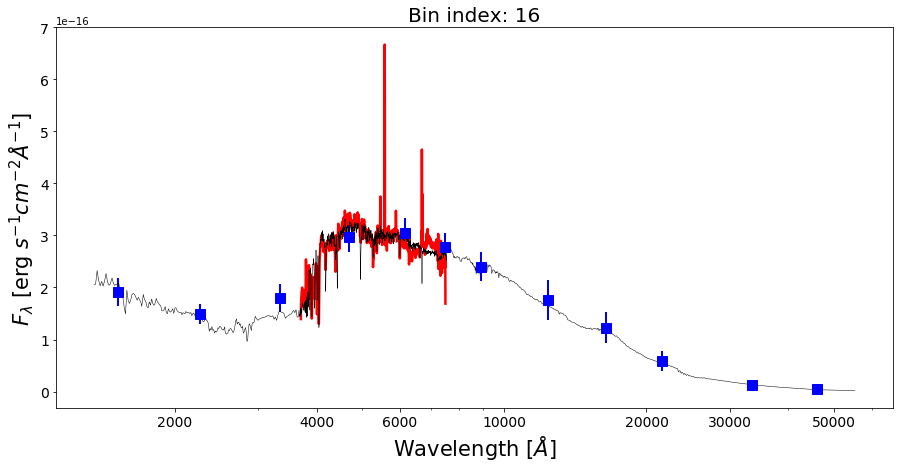

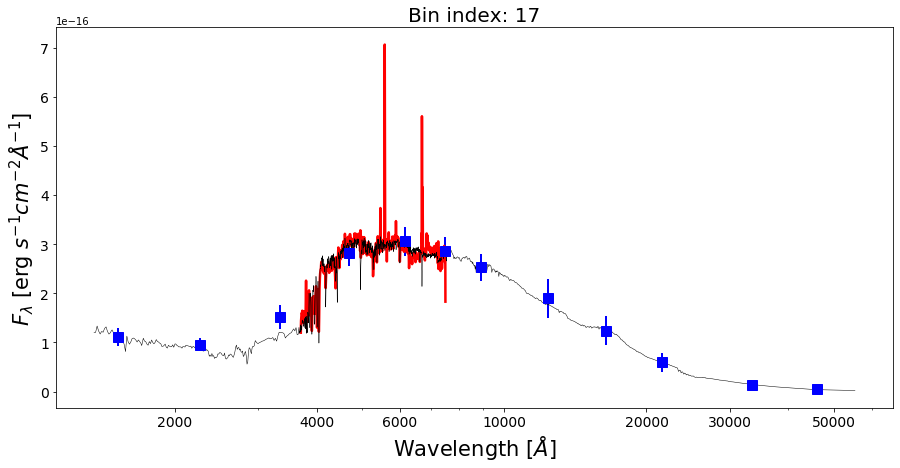

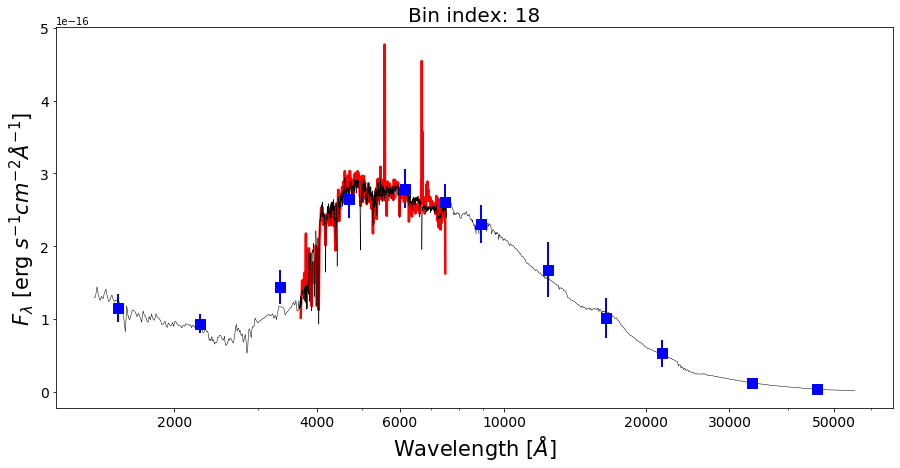

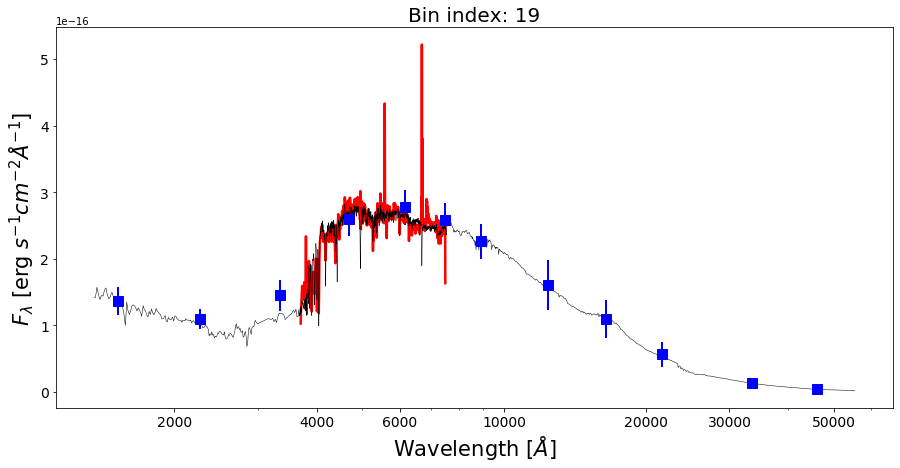

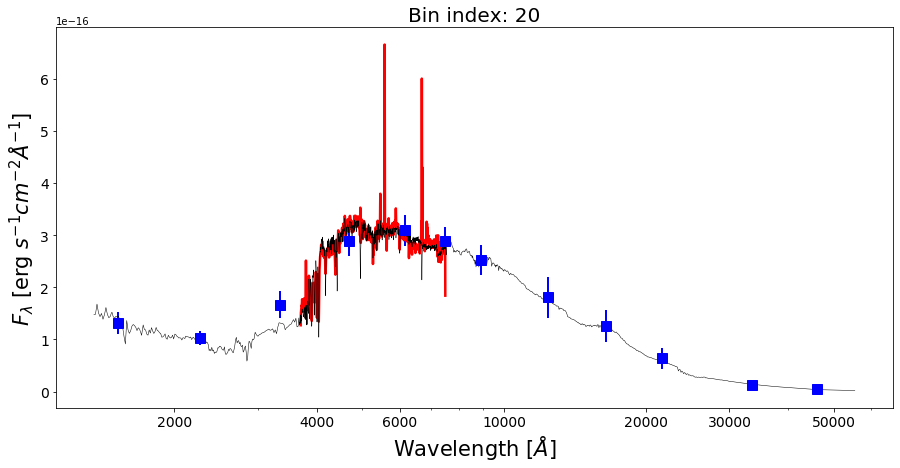

In [10]:
for ii in range(0,20):
    fig1 = plt.figure(figsize=(15,7))
    f1 = plt.subplot()   
    plt.title("Bin index: %d" % (ii+1), fontsize=20)
    #f1.set_yscale('log')
    f1.set_xscale('log')
    plt.setp(f1.get_yticklabels(), fontsize=14)
    plt.setp(f1.get_xticklabels(), fontsize=14)
    plt.xlabel(r'Wavelength $[\AA]$', fontsize=21)
    plt.ylabel(r'$F_{\lambda}$ [erg $s^{-1}cm^{-2}\AA^{-1}$]', fontsize=21)
    xticks = [2000,4000,6000,10000,20000,30000,50000]
    plt.xticks(xticks)
    #plt.xlim(3000,10000)
    #plt.ylim(6.5e-19,2e-16)
    for axis in [f1.xaxis]:
        axis.set_major_formatter(ScalarFormatter())

    if np.sum(bin_spec_SED[ii])>0:
        plt.plot(spec_wave, bin_spec_SED[ii], lw=2.5, color='red')
        
    plt.errorbar(photo_wave, bin_photo_SED[ii], yerr=bin_photo_SED_err[ii], markersize=10,
                            color='blue', fmt='s', lw=2)
    if np.sum(bin_spec_SED[ii])>0:
        plt.plot(mod_wave, bin_mod_SED[ii], lw=0.5, color='black')

    name_out = "sed_bin_%d_wmod.png" % (ii+1)
    plt.savefig(name_out)